In [1]:
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import json
from typing import Union, List
import matplotlib.patches as mpatches
import scipy.stats as stats
import numpy as np
from scipy.stats import shapiro
import math
import matplotlib.ticker as ticker
import plotly.express as px

sns.set_palette("pastel")

## 1. Laden des Rohdatensatzes

### 1.1 Laden der Frage-Codes

Zur besseren Verarbeitung der Datensätze werden die zugehörigen Codes der Fragen geladen und verwendet. 

In [2]:
with open('code.json', 'r') as f:
  code_data = json.load(f)

In [3]:
df_code = pd.DataFrame(code_data)
codes = df_code["Variable"].tolist()

In [4]:
df_code.head()

,Variable,Fragetyp,Fragetext,Werte,Zeichenlimit,Wert
0,60371597,Skalafrage,2.1 ein hohes Einkommen,"{'<leer>': 'Ungültig / Keine Antwort', '1': 'u...",None,None
1,60371598,Skalafrage,2.2 gute Aufstiegsmöglichkeiten,"{'<leer>': 'Ungültig / Keine Antwort', '1': 'u...",None,None
2,60371599,Skalafrage,2.3 einen sicheren Arbeitsplatz,"{'<leer>': 'Ungültig / Keine Antwort', '1': 'u...",None,None
3,60371600,Skalafrage,2.4 viele Kontakte zu anderen Menschen,"{'<leer>': 'Ungültig / Keine Antwort', '1': 'u...",None,None
4,60371601,Skalafrage,2.5 eine gute/kollegiale Arbeitsatmosphäre,"{'<leer>': 'Ungültig / Keine Antwort', '1': 'u...",None,None


### 1.2 Laden der Stichproben Ergebnisse

Die Stichproben Ergebnisse werden in ein DataFrame geladen und die Spaltenüberschriften (Fragetexte) mit ihren jeweiligen Codes ersetzt.

In [5]:
df_results_raw = pd.read_csv('./data/pia_master.csv', sep=";")

In [6]:
print(len(codes))
print(len(df_results_raw.columns))

53
56


In [7]:
df_results_raw.head()

,Bogen,ein hohes Einkommen,gute Aufstiegsmöglichkeiten,einen sicheren Arbeitsplatz,viele Kontakte zu anderen Menschen,eine gute/kollegiale Arbeitsatmosphäre,"das Gefühl, etwas zu leisten","das Gefühl, anerkannt zu werden","Möglichkeiten, sich um andere Menschen zu kümmern","Möglichkeiten, eigene Ideen einzubringen",...,an Gott glauben,die Vielfalt der Menschen anerkennen und respektieren,"Bitte kreuze an, welcher Generation du zugehörig bist:",Welchem Geschlecht fühlst du dich zugehörig?,Bitte wähle deinen höchsten formalen Bildungsabschluss aus:,Bist du derzeit berufstätig?,In welcher Beschäftigungsform befindest du dich?,In welchem Wirtschaftssektor bist du beschäftigt?,Zeitstempel,Datensatz-Ursprung
0,1,4,4,5,4,4,5,5,4,4,...,2,5,2,2.0,6,1,1.0,3.0,02.07.2023 um 17:44:14,O
1,2,4,5,5,5,5,4,5,4,4,...,1,5,1,2.0,6,1,1.0,2.0,02.07.2023 um 17:50:50,O
2,3,4,2,5,4,5,4,5,2,4,...,2,3,1,1.0,4,1,1.0,3.0,02.07.2023 um 18:55:10,M
3,4,5,4,5,4,4,4,4,2,3,...,1,5,1,2.0,4,1,2.0,3.0,02.07.2023 um 19:00:41,M
4,5,5,4,5,3,5,5,4,3,4,...,1,4,1,2.0,5,1,1.0,3.0,02.07.2023 um 19:03:32,M


### 1.3. Utility Functions

In [14]:
def get_answer_text(question_code: str, answer_res: Union[float, int, str] = None):
    if isinstance(answer_res, str):
        _res = answer_res
    else:
        _res = int(answer_res) if answer_res != 0 else '<leer>'
    t_code = df_code[df_code["Variable"] == question_code]
    question_type = t_code["Fragetyp"].values[0]
    assert (answer_res is not None and question_type != 'Offene Frage') or (answer_res is None and question_type == 'Offene Frage'), f"Ungültige Antwortmöglichkeit für Fragentyp {question_type}"
    answer_dict = t_code["Werte"].values[0]
    out = answer_dict[str(_res)] if answer_res is not None else answer_dict
    return out

In [15]:
def get_question_text(question_code: str):
    return df_code[df_code["Variable"] == question_code]["Fragetext"].values[0]

### 1.4 Gliederung der Fragetypen

Die Umfrage enthält 3 Fragetypen.
- Skalafragen - Antwortmöglichkeiten werden mittels kategorischen numerischen Werten auf einer Ordinalskala dargestellt.
- 1 aus n - Antwortmöglichkeiten werden mittels kategorischen numerischen Werten auf einer Nominalskala dargestellt.
- Offene Frage - Antwort besteht aus einem Freitext

In [10]:
skala_ids = df_code[df_code["Fragetyp"] == "Skalafrage"]["Variable"].tolist()
one_of_n_ids = df_code[df_code["Fragetyp"] == "1 aus n"]["Variable"].tolist()
numeric_ids = skala_ids + one_of_n_ids
open_q_ids = df_code[df_code["Fragetyp"] == "Offene Frage"]["Variable"].tolist()

Neben den fachlichen Fragen der Umfrage, gibt es auch Fragetypen, welche zur Klassifierung der Umfrage Ergebnisse dienen.
- Bitte kreuze an, welcher Generation du zugehörig bist
- Welchem Geschlecht fühlst du dich zugehörig?
- Bitte wähle deinen höchsten formalen Bildungsabschluss aus:
- Bist du derzeit berufstätig?
- In welcher Beschäftigungsform befindest du dich?
- In welchem Wirtschaftssektor bist du beschäftigt?

In [11]:
generation_col = '60371649'
gender_col = '60371650'
academic_col = '60371651'
working_col = '60371652'
work_form_col = '60371653'
economic_sector_col = '60371654'

In [12]:
skala_fach_ids = [x for x in skala_ids if int(x) <= 60371648]
one_of_n_fach_ids = [x for x in one_of_n_ids if int(x) <= 60371648]
num_fach_cols = skala_fach_ids + one_of_n_fach_ids

print(skala_fach_ids)
print(one_of_n_fach_ids)

['60371597', '60371598', '60371599', '60371600', '60371601', '60371602', '60371603', '60371604', '60371605', '60371606', '60371607', '60371608', '60371609', '60371615', '60371616', '60371617', '60371618', '60371619', '60371620', '60371624', '60371625', '60371626', '60371627', '60371628', '60371629', '60371630', '60371631', '60371632', '60371633', '60371634', '60371635', '60371636', '60371637', '60371638', '60371639', '60371640', '60371641', '60371642', '60371643', '60371644', '60371645', '60371646', '60371647', '60371648']
['60371613', '60371614']


In [16]:
for col in num_fach_cols:
    print(f"{col}: {get_question_text(col)}")

60371597: 2.1 ein hohes Einkommen
60371598: 2.2 gute Aufstiegsmöglichkeiten
60371599: 2.3 einen sicheren Arbeitsplatz
60371600: 2.4 viele Kontakte zu anderen Menschen
60371601: 2.5 eine gute/kollegiale Arbeitsatmosphäre
60371602: 2.6 das Gefühl, etwas zu leisten
60371603: 2.7 das Gefühl, anerkannt zu werden
60371604: 2.8 Möglichkeiten, sich um andere Menschen zu kümmern
60371605: 2.9 Möglichkeiten, eigene Ideen einzubringen
60371606: 2.10 Möglichkeiten, etwas Nützliches für die Gesellschaft zu tun
60371607: 2.11 die Möglichkeit, etwas zu tun, das ich sinnvoll ﬁnde
60371608: 2.12 genügend Freizeit neben der Berufstätigkeit
60371609: 2.13 Flexible Arbeitszeiten (z.B. Home-Ofﬁce oder Gleitzeit)
60371615: 4.1 Größe des Unternehmens
60371616: 4.2 Ruf des Unternehmens
60371617: 4.3 Standort des Unternehmens
60371618: 4.4 Bereitstellung neuster Technologien am Arbeitsplatz
60371619: 4.5 Flache Hierarchien (auf Augenhöhe miteinander arbeiten)
60371620: 4.6 Nachhaltigkeit  Corporate Social Resp

In [17]:
erwartungen_ids = [x for x in codes if 60371597 <= int(x) and int(x) <= 60371609] + [x for x in codes if 60371615 <= int(x) and int(x) <= 60371620]
print(erwartungen_ids)

['60371597', '60371598', '60371599', '60371600', '60371601', '60371602', '60371603', '60371604', '60371605', '60371606', '60371607', '60371608', '60371609', '60371615', '60371616', '60371617', '60371618', '60371619', '60371620']


In [18]:
werte_ids = [x for x in codes if 60371624 <= int(x) and int(x) <= 60371648]
print(werte_ids)

['60371624', '60371625', '60371626', '60371627', '60371628', '60371629', '60371630', '60371631', '60371632', '60371633', '60371634', '60371635', '60371636', '60371637', '60371638', '60371639', '60371640', '60371641', '60371642', '60371643', '60371644', '60371645', '60371646', '60371647', '60371648']


## 2. Pre Processing

Bevor wir mit der Analyse der Umfrageergebnisse starten können, müssen einige Pre Processing Schritte vollzogen werden, um die Daten fachlich aufzubereiten.

Punkte die dabei beachtet werden müssen sind:
- Behandlung von fehlenden/falschen Werten
- Standarisierung der Ergeniss-Typen

Im ersten Schritte werden ungültige Werte ausgewertet.

<Axes: >

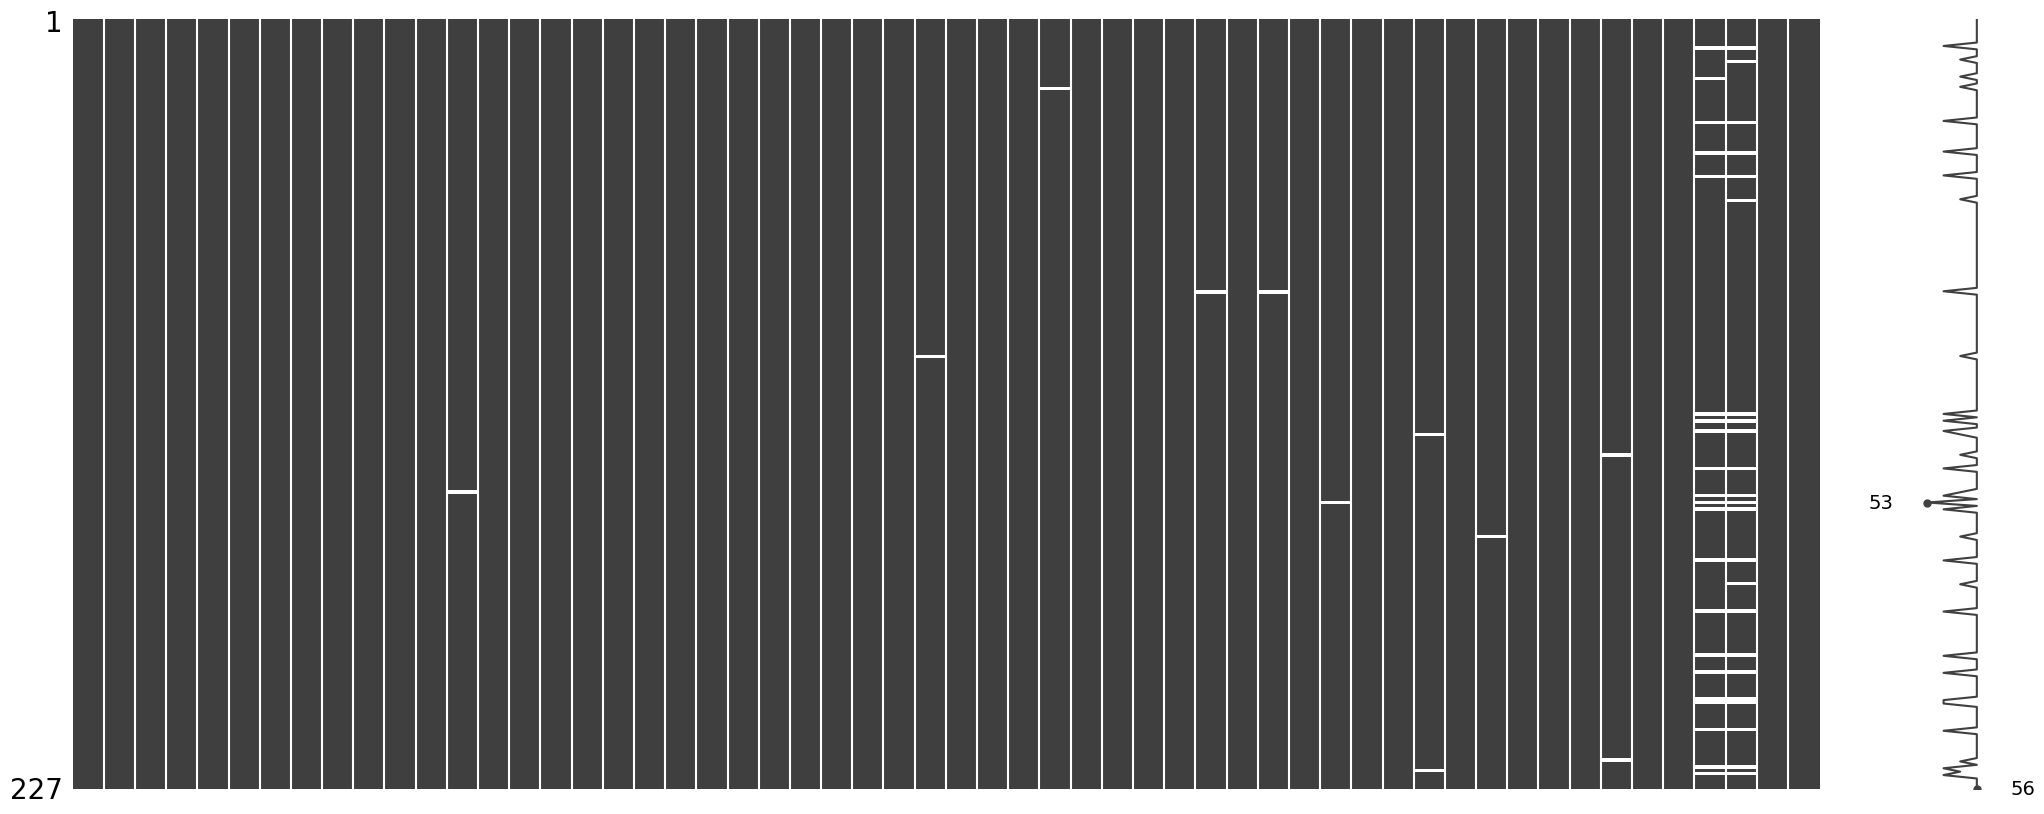

In [19]:
msno.matrix(df_results)

In [20]:
pd.crosstab(index=df_results[generation_col], columns=[academic_col])

col_0,60371651
60371649,
1,109
2,96
3,22


Im weiteren Verlauf werden nur noch die Generationen Y und Z verglichen. Die restlichen Generationen werden aussortiert.

In [21]:
df_yz = df_results[df_results['60371649'] != 3]

In [22]:
df_yz.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205 entries, 0 to 226
Data columns (total 56 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Bogen               205 non-null    int64  
 1   60371597            205 non-null    int64  
 2   60371598            205 non-null    int64  
 3   60371599            205 non-null    int64  
 4   60371600            205 non-null    int64  
 5   60371601            205 non-null    int64  
 6   60371602            205 non-null    int64  
 7   60371603            205 non-null    int64  
 8   60371604            205 non-null    int64  
 9   60371605            205 non-null    int64  
 10  60371606            205 non-null    int64  
 11  60371607            205 non-null    int64  
 12  60371608            205 non-null    float64
 13  60371609            205 non-null    int64  
 14  60371612            205 non-null    object 
 15  60371613            205 non-null    int64  
 16  60371614     

Wir betrachten die fehlenden Werte genauer, um zu entscheiden, wie wir mit diesen Werten umgehen möchten.

<Axes: >

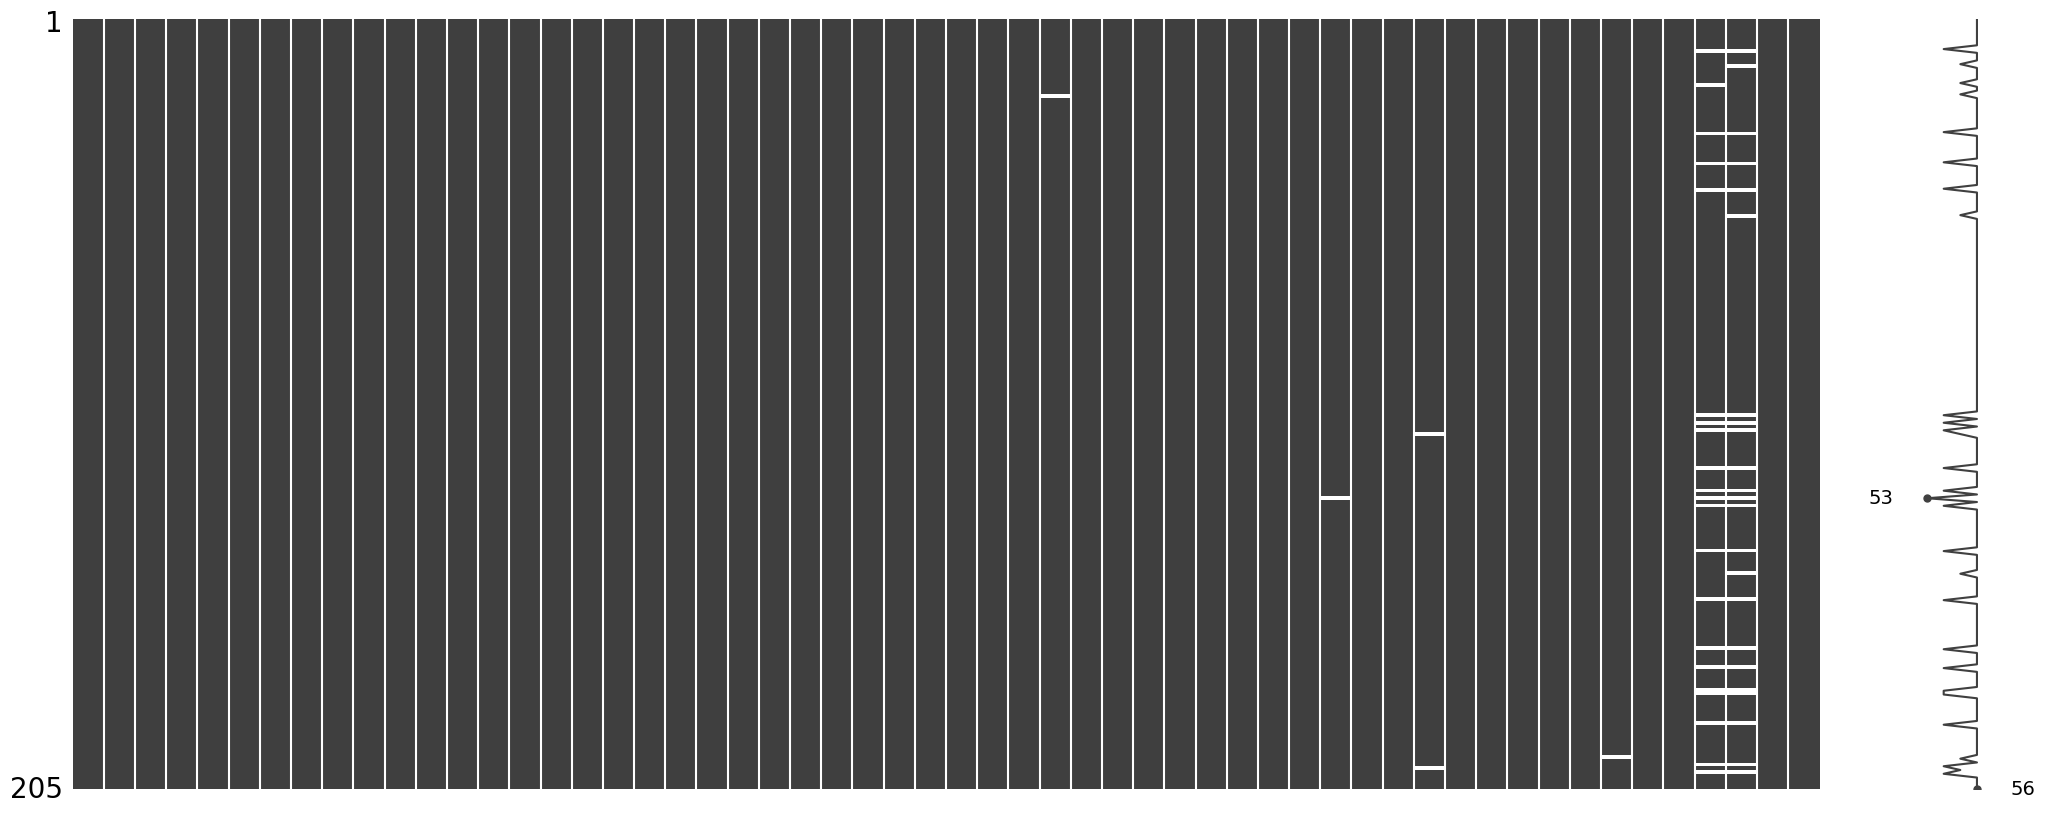

In [23]:
msno.matrix(df_yz)

Wir können feststellen, dass die meisten fehlenden Werte in den Fragen 60371653 und 60371653 vorkommen. Ansonten existieren so gut wie keine fehlenden Werte. Da es sich bei den Fragen 60371653 und 60371653 um Fragen zur Einordung der Befragten handelt. Füllen wir diese Werte mit 0 auf. Außerdem bereinigen wir unseren Datensatz, indem wir die restlichen Stichproben mit fehlenden Daten entfernen.

In [25]:
df_yz = df_yz.dropna(subset=['60371632', '60371641', '60371644', '60371650'])
df_yz.fillna(0, inplace=True)
df_yz[skala_ids] = df_yz[skala_ids].applymap(np.int64)

Das einfache Pre Processing der Daten ist damit abgeschlossen. Die aufbereiteten speichern wir in einem parquet File ab. Zur einfacherern Weiterverarbeitung kann dieser Datensatz geladen werden

In [26]:
table_yz = pa.Table.from_pandas(df_yz)
pq.write_table(table_yz, 'results_preprocessed.parquet')